In [1]:
import numpy as np
import astropy.units as u

from astropy.table import Table, QTable, Column
from os import listdir, rename
from matplotlib import pyplot as plt


def perform_Gaia_query(G_lim):
    """Perform a query from Gaia DR2.

    The query will include all the stars brighter with G<G_lim that also have a 5-parameter
    astrometric solution together with BP and RP measurements. Their astrometric parameters,
    uncertainties and correlations together with G, BP and RP magnitudes are saved to a VOTable.
    The name of the VOTable file is returned.
    """
    from astroquery.gaia import Gaia

    astrometry = ('ra', 'dec', 'parallax', 'pmra', 'pmdec')
    columns_to_query = ''
    # Add astrometric measurements, uncertanties and correlations to the columns to be queried
    for i, col in enumerate(astrometry):
        columns_to_query += col+', '
        columns_to_query += col+'_error, '
        for col2 in astrometry[i+1:]:
            columns_to_query += col+'_'+col2+'_corr, '
    # Make sure the magnitudes in the three bands are queried too
    for band in ('g', 'bp', 'rp'):
        columns_to_query += 'phot_'+band+'_mean_mag, '
    # Remove the last comma
    columns_to_query = columns_to_query[:-2]
    job = Gaia.launch_job_async(f'SELECT {columns_to_query}\
                                 FROM gaiadr2.gaia_source\
                                 WHERE phot_g_mean_mag < {G_lim}\
                                     AND parallax IS NOT NULL\
                                     AND bp_rp IS NOT NULL\
                                 ;', dump_to_file=True)
    return job.outputFile


G_lim = 11
filename = f'brighter_than_{G_lim}.vot'
if filename not in listdir():
    print('Performing a query from Gaia archive. This might take a while...')
    rename(perform_Gaia_query(G_lim), filename)
else:
    print('Reading data from a stored file.')
data = QTable.read(filename)
# Astropy QTable has problems parsing the proper motion units, so we have to help it along.
for col in data.columns:
    if 'pm' in col and 'corr' not in col:
        data[col] = np.array(data[col])*u.Unit(str(data[col].unit))
print('Done.')

Reading data from a stored file.
Done.


In [2]:
def construct_covariance_matrix(stars):
    """Create the covariance matrix of the astrometric parameters of input stars."""
    covariance = np.ones((len(stars), 5, 5))
    astrometry = ('ra', 'dec', 'parallax', 'pmra', 'pmdec')
    for i, col in enumerate(astrometry):
        # This covariance matrix is set up as a numpy array, so we need to strip the units.
        covariance[:, i, :] *= np.array(stars[col+'_error'])[:, np.newaxis]
        covariance[:, :, i] *= np.array(stars[col+'_error'])[:, np.newaxis]
        for j in range(i+1, 5):
            covariance[:, i, j] *= np.array(stars[col+'_'+astrometry[j]+'_corr'])
            covariance[:, j, i] = covariance[:, i, j]
    return covariance


def convert_icrs_to_gal(stars):
    """Convert coordinates from ICRS to the Galactic system."""
    from coordTransform import transformIcrsToGal
    gal_params = ('l', 'b', 'pml', 'pmb')
    coords = np.array(stars['ra', 'dec', 'parallax', 'pmra', 'pmdec']).view((float, 5))
    covariance = construct_covariance_matrix(stars)
    gal_coords, gal_uncerts, gal_covariance = transformIcrsToGal(coords, 0, EqC=covariance)
    temp = QTable(gal_coords[:, np.array((0, 1, 3, 4))], names=gal_params)
    stars.add_columns(temp.columns.values())
    for i, name, unit, err_unit in zip((0, 1, 3, 4), gal_params,
                                       (u.deg, u.deg, u.mas/u.yr, u.mas/u.yr),
                                       (u.mas, u.mas, u.mas/u.yr, u.mas/u.yr)):
        stars[name] *= unit
        stars.add_column(Column(np.sqrt(gal_covariance[:, i, i])), name=name+'_error')
        # Right ascension and declination are in deg, but their uncertanties in mas.
        # We must ensure the same for galactic longitude and latitude.
        stars[name+'_error'] *= err_unit
    return stars


# Don't compute the galactic coordinates if they are already computed.
if 'b' not in data.columns:
    data = convert_icrs_to_gal(data)

In [124]:
'''Calculating Tmean, taumean and vmeans'''

filters = [(data['parallax'] > 10*data['parallax_error']) &
                    (data['phot_bp_mean_mag'].value - data['phot_rp_mean_mag'].value > i) &
                    ((data['phot_bp_mean_mag'].value - data['phot_rp_mean_mag'].value) < i+0.1) for i in np.arange(-0.3,0.8,0.1)]
F = [data[filters[i]] for i in range(len(filters))]
N = [len(F[i]) for i in range(len(filters))]

app = [np.reshape(F[i]['phot_g_mean_mag'].value,(1,len(F[i]))) for i in range(len(N))]
p = [np.reshape(F[i]['parallax'].value,(1,len(F[i]))) for i in range(len(N))]
parallax = [np.reshape(F[i]['parallax'],(1,N[i])) for i in range(len(N))]
longitude = [F[i]['l'] for i in range(len(N))]
latitude = [F[i]['b'] for i in range(len(N))]
mu_l = [np.reshape(F[i]['pml'],(1,N[i])) for i in range(len(N))]
mu_b = [np.reshape(F[i]['pmb'],(1,N[i])) for i in range(len(N))]
r = [np.reshape(parallax[i].to(u.kpc, equivalencies=u.parallax()),(1,N[i])) for i in range(len(N))]
K = 4.7405 *u.km * u.yr / u.s / u.kpc / u.mas

l = [np.array([-np.sin(longitude[i]), np.cos(longitude[i]), np.zeros(len(F[i]))]) for i in range(len(N))]
b = [np.array([-np.sin(latitude[i])*np.cos(longitude[i]), -np.sin(latitude[i])*np.sin(longitude[i]), np.cos(latitude[i])]) for i in range(len(N))]


Tm = []
taum = []
v_m = []
for j in range(len(N)):
    t1 = (l[j]*K*mu_l[j])*r[j]
    t2 = (b[j]*K*mu_b[j])*r[j]
    tau = t1 + t2
    Tmean = np.zeros((3,3))
    for i in range(N[j]): #i = star
        u_1 = np.reshape(np.array([np.cos(latitude[j][i])*np.cos(longitude[j][i]), np.cos(latitude[j][i])*np.sin(longitude[j][i]), np.sin(latitude[j][i])]), (1,3))
        T = np.eye(3) - np.outer(u_1,np.transpose(u_1))
        Tmean += T

    Tmean /= N[j]
    Tm.append(Tmean)
    
    taumean = tau.mean(axis=1)
    taum.append(taumean)

    v_avv = np.matmul(np.linalg.inv(Tmean),taumean)
    v_m.append(v_avv)
    print(j)


0
1
2
3
4
5
6
7
8
9
10


In [126]:
v_m

[<Quantity [-17.55330565,  -8.01913704,  -8.44976335] km / s>,
 <Quantity [-19.57984151, -12.34681869,  -8.93674623] km / s>,
 <Quantity [-19.97145221, -15.04249567,  -8.74697281] km / s>,
 <Quantity [-18.5339902 , -15.16907546,  -8.06195866] km / s>,
 <Quantity [-15.55090658, -14.90186078,  -7.68071746] km / s>,
 <Quantity [-13.73247613, -14.41337313,  -7.43333228] km / s>,
 <Quantity [-13.03320824, -13.63045878,  -7.57120539] km / s>,
 <Quantity [-11.86751266, -13.50920606,  -7.62669467] km / s>,
 <Quantity [-10.39400528, -13.06549696,  -7.41388704] km / s>,
 <Quantity [ -9.43622595, -14.47083049,  -7.37493958] km / s>,
 <Quantity [ -8.81896533, -18.61523961,  -7.50159086] km / s>]

In [127]:
'''Calculating B-matrix'''

Bm = []
for j in range(len(N)):
    B = np.zeros((3,3))
    for i in range(N[j]):    
        u_1 = np.reshape([np.cos(latitude[j][i])*np.cos(longitude[j][i]), np.cos(latitude[j][i])*np.sin(longitude[j][i]), np.sin(latitude[j][i])], (1,3))
        T = np.eye(3) - np.outer(u_1,np.transpose(u_1))

        l_1 = np.array([-np.sin(longitude[j][i]), np.cos(longitude[j][i]), np.zeros(len(F[j]))[i]])
        b_1 = np.array([-np.sin(latitude[j][i])*np.cos(longitude[j][i]), -np.sin(latitude[j][i])*np.sin(longitude[j][i]), np.cos(latitude[j][i])])

        t1 = (l_1*K*mu_l[j][0][i])*r[j][0][i]
        t2 = (b_1*K*mu_b[j][0][i])*r[j][0][i]
        tau = t1 + t2

        deltatau = tau - np.matmul(T,v_m[j])
        B = B + np.outer(deltatau,np.transpose(deltatau))

    B /= N[j]
    Bm.append(B)
    print(j)

0
1
2
3
4
5
6
7
8
9
10


In [431]:
Bm

[<Quantity [[ 448.49080384, -108.65122962,  -17.77591545],
            [-108.65122962,  126.94460051,  -52.28453175],
            [ -17.77591545,  -52.28453175,  294.34585109]] km2 / s2>,
 <Quantity [[372.77975396, -50.41831661,  36.93123208],
            [-50.41831661, 112.95620221, -20.63028476],
            [ 36.93123208, -20.63028476,  96.47651542]] km2 / s2>,
 <Quantity [[340.51345512, -40.9365262 ,   8.25028877],
            [-40.9365262 , 132.4142307 ,  -1.32092105],
            [  8.25028877,  -1.32092105,  84.9669127 ]] km2 / s2>,
 <Quantity [[343.9547999 ,   1.74530563,  15.51080715],
            [  1.74530563, 160.40257247,   6.42832307],
            [ 15.51080715,   6.42832307,  82.39492365]] km2 / s2>,
 <Quantity [[393.11379638,  26.64563988,   9.0008825 ],
            [ 26.64563988, 171.11090905,  -1.58574362],
            [  9.0008825 ,  -1.58574362,  94.75412604]] km2 / s2>,
 <Quantity [[398.23336157,  45.97940318,  14.04142475],
            [ 45.97940318, 173.23272745,

In [145]:
'''Calculating D matrix, dispersion and non-redundant elements'''

Dm = []
disp = []
dm = []
for j in range(len(N)):  
    D = np.zeros((3,3))*u.km**2/(u.s**2)
    for i in range(3):
        for k in range(3):
            for m in range(3):
                for n in range(3):
                    if m <= n:
                        D[m,n] += Bm[j][i,k]/(Tm[j][k,m]*Tm[j][i,n])

    Dm.append(D)
    dispersions = np.diag(D)
    disp.append(dispersions)
    d = D[D!=0]
    dm.append(d)
disp

[<Quantity [66374.38150327, 70527.46884094, 84423.12557565] km2 / s2>,
 <Quantity [ 84287.52940385,  68789.69198785, 326680.49623032] km2 / s2>,
 <Quantity [ 3312642.77406886,   375431.66731698, 14748638.47053324] km2 / s2>,
 <Quantity [  402890.94487241,  5850474.65699385, 12433101.18424038] km2 / s2>,
 <Quantity [ 1609240.00342568, 16462042.1492394 , 25914328.67008122] km2 / s2>,
 <Quantity [ 2483150.02321727, 20244828.02718562, 31705486.1688203 ] km2 / s2>,
 <Quantity [1534250.0266803 , 5183256.65436368, 8730789.63361042] km2 / s2>,
 <Quantity [ 8188023.25315274, 17522009.74744113,  6157774.69514736] km2 / s2>,
 <Quantity [4676997.69610173, 9916964.67631388, 1793451.63903219] km2 / s2>,
 <Quantity [ 4654055.29305745, 10421576.4667489 ,  3459241.13494065] km2 / s2>,
 <Quantity [1.60367522e+07, 1.21258836e+08, 1.66616121e+08] km2 / s2>]

In [153]:
Tm

[array([[ 0.68566095, -0.19645412, -0.06588431],
        [-0.19645412,  0.39650602, -0.0737025 ],
        [-0.06588431, -0.0737025 ,  0.91783302]]),
 array([[ 0.69775186, -0.15081996, -0.0329001 ],
        [-0.15081996,  0.39935699, -0.05024474],
        [-0.0329001 , -0.05024474,  0.90289115]]),
 array([[ 0.64731758, -0.12015363,  0.00508017],
        [-0.12015363,  0.43070484, -0.01579744],
        [ 0.00508017, -0.01579744,  0.92197758]]),
 array([[ 0.6310826 , -0.0601753 ,  0.01494646],
        [-0.0601753 ,  0.43910737, -0.00382635],
        [ 0.01494646, -0.00382635,  0.92981003]]),
 array([[ 0.60800112, -0.01346558,  0.01208253],
        [-0.01346558,  0.45815941, -0.00262138],
        [ 0.01208253, -0.00262138,  0.93383946]]),
 array([[ 0.59379424,  0.01111453,  0.01026626],
        [ 0.01111453,  0.48309771, -0.00233524],
        [ 0.01026626, -0.00233524,  0.92310805]]),
 array([[ 0.59015967,  0.01679466,  0.00978157],
        [ 0.01679466,  0.5047395 , -0.00479677],
        

In [572]:
'''First try'''
Amean = []
displist = []
for i in range(len(N)):
    T_11 = Tm[i][0,0]
    T_12 = Tm[i][0,1]
    T_13 = Tm[i][0,2]
    T_21 = Tm[i][1,0]
    T_22 = Tm[i][1,1]
    T_23 = Tm[i][1,2]
    T_31 = Tm[i][2,0]
    T_32 = Tm[i][2,1]
    T_33 = Tm[i][2,2]
    A = np.array([[T_11*T_11, T_11*T_12 + T_12*T_11, T_11*T_13 + T_13*T_11, T_12*T_12, T_12*T_13 + T_13*T_12, T_13*T_13],
                 [T_11*T_21, T_11*T_22 + T_12*T_21, T_11*T_23 + T_13*T_21, T_12*T_22, T_12*T_23 + T_13*T_22, T_13*T_23],
                 [T_11*T_31, T_11*T_32 + T_12*T_31, T_11*T_33 + T_13*T_31, T_12*T_32, T_12*T_33 + T_13*T_32, T_13*T_33],
                 [T_21*T_21, T_21*T_22 + T_22*T_21, T_21*T_23 + T_23*T_21, T_22*T_22, T_22*T_23 + T_23*T_22, T_23*T_23],
                 [T_21*T_31, T_21*T_32 + T_22*T_31, T_21*T_33 + T_23*T_31, T_22*T_32, T_22*T_33 + T_23*T_32, T_23*T_33],
                 [T_31*T_31, T_31*T_32 + T_32*T_31, T_31*T_33 + T_33*T_31, T_32*T_32, T_32*T_33 + T_33*T_32, T_33*T_33]])
    B11 = Bm[i][0][0].value
    B12 = Bm[i][0][1].value
    B13 = Bm[i][0][2].value
    B22 = Bm[i][1,1].value
    B23 = Bm[i][1,2].value
    B33 = Bm[i][2,2].value
    
    b = np.array([[B11,B12,B13,B22,B23,B33]])
    Ainv = np.linalg.inv(A)
    Am = Ainv.mean(axis = 0)
    dispers = np.outer(Ainv,b)
    displist.append(dispers)
  
    
    
disp_x = []
disp_y = []
disp_z = []
Dlist = [] #Non-redunant elements

for i in range(len(N)):
    Dlist.append(displist[i][0])
    disp_x.append(displist[i][0][0])
    disp_y.append(displist[i][0][3])
    disp_z.append(displist[i][0][5])


In [437]:
Amean = []
displist = []
for i in range(len(N)):
    T_11 = Tm[i][0,0]
    T_12 = Tm[i][0,1]
    T_13 = Tm[i][0,2]
    T_21 = Tm[i][1,0]
    T_22 = Tm[i][1,1]
    T_23 = Tm[i][1,2]
    T_31 = Tm[i][2,0]
    T_32 = Tm[i][2,1]
    T_33 = Tm[i][2,2]
    A = np.array([[T_11*T_11, T_11*T_12 + T_12*T_11, T_11*T_13 + T_13*T_11, T_12*T_12, T_12*T_13 + T_13*T_12, T_13*T_13],
                 [T_11*T_21, T_11*T_22 + T_12*T_21, T_11*T_23 + T_13*T_21, T_12*T_22, T_12*T_23 + T_13*T_22, T_13*T_23],
                 [T_11*T_31, T_11*T_32 + T_12*T_31, T_11*T_33 + T_13*T_31, T_12*T_32, T_12*T_33 + T_13*T_32, T_13*T_33],
                 [T_21*T_21, T_21*T_22 + T_22*T_21, T_21*T_23 + T_23*T_21, T_22*T_22, T_22*T_23 + T_23*T_22, T_23*T_23],
                 [T_21*T_31, T_21*T_32 + T_22*T_31, T_21*T_33 + T_23*T_31, T_22*T_32, T_22*T_33 + T_23*T_32, T_23*T_33],
                 [T_31*T_31, T_31*T_32 + T_32*T_31, T_31*T_33 + T_33*T_31, T_32*T_32, T_32*T_33 + T_33*T_32, T_33*T_33]])
    B11 = Bm[i][0,0].value
    B12 = Bm[i][0,1].value
    B13 = Bm[i][0,2].value
    B22 = Bm[i][1,1].value
    B23 = Bm[i][1,2].value
    B33 = Bm[i][2,2].value
    
    b = np.array([[B11,B12,B13,B22,B23,B33]])
    print(T_11)
    #bm = np.mean(b)
    #print(A)
    Ainv = np.linalg.inv(A)
    Am = Ainv.mean(axis = 0)
    dispers = np.outer(Ainv,b)
    displist.append(dispers)
  
    
    
disp_x = []
disp_y = []
disp_z = []
for i in range(len(N)):
    print(displist[i][0])
    disp_x.append(displist[i][0][0])
    disp_y.append(displist[i][0][3])
    disp_z.append(displist[i][0][5])
  
    




0.6856609525596167
0.697751860628466
0.6473175810277048
0.6310826021100037
0.6080011229887891
0.5937942365286641
0.5901596704469118
0.6054483508993466
0.6360220769196177
0.666143439356468
0.6539787468462632
[2175.06830089  127.5163643    18.6096732  1110.24823846   12.32847567
  800.16209667]
[1778.5071496   104.26742255   15.21673449  907.82640211   10.08073269
  654.27555042]
[1920.27408311  112.57870359   16.42967861  980.19033116   10.88427995
  706.42863762]
[1866.2865518   109.41361047   15.96776653  952.63277744   10.57827395
  686.56775498]
[1960.61097926  114.94350949   16.77479717 1000.78001465   11.11291298
  721.26773733]
[2054.39989135  120.44201318   17.577246   1048.65390182   11.64451666
  755.77071478]
[2081.89411307  122.05389966   17.81248389 1062.68813294   11.80035629
  765.88526341]
[1974.7952628   115.77508258   16.89615653 1008.02028191   11.19331073
  726.48583832]
[1790.7391996   104.98454327   15.32139072  914.07016556   10.15006501
  658.77546556]
[1633.1161

In [362]:
Amean = np.zeros((11,6,6))
displist = []
for i in range(len(N)):
    T_11 = Tm[i][0,0]
    T_12 = Tm[i][0,1]
    T_13 = Tm[i][0,2]
    T_21 = Tm[i][1,0]
    T_22 = Tm[i][1,1]
    T_23 = Tm[i][1,2]
    T_31 = Tm[i][2,0]
    T_32 = Tm[i][2,1]
    T_33 = Tm[i][2,2]
    A = np.array([[T_11*T_11, T_11*T_12 + T_12*T_11, T_11*T_13 + T_13*T_11, T_12*T_12, T_12*T_13 + T_13*T_12, T_13*T_13],
                 [T_11*T_21, T_11*T_22 + T_12*T_21, T_11*T_23 + T_13*T_21, T_12*T_22, T_12*T_23 + T_13*T_22, T_13*T_23],
                 [T_11*T_31, T_11*T_32 + T_12*T_31, T_11*T_33 + T_13*T_31, T_12*T_32, T_12*T_33 + T_13*T_32, T_13*T_33],
                 [T_21*T_21, T_21*T_22 + T_22*T_21, T_21*T_23 + T_23*T_21, T_22*T_22, T_22*T_23 + T_23*T_22, T_23*T_23],
                 [T_21*T_31, T_21*T_32 + T_22*T_31, T_21*T_33 + T_23*T_31, T_22*T_32, T_22*T_33 + T_23*T_32, T_23*T_33],
                 [T_31*T_31, T_31*T_32 + T_32*T_31, T_31*T_33 + T_33*T_31, T_32*T_32, T_32*T_33 + T_33*T_32, T_33*T_33]])
    B11 = Bm[j][0][0].value
    B12 = Bm[j][0][1].value
    B13 = Bm[j][0][2].value
    B22 = Bm[j][1,1].value
    B23 = Bm[j][1,2].value
    B33 = Bm[j][2,2].value
    
    b = np.array([[B11,B12,B13,B22,B23,B33]])
    Am = A.mean(axis = 1)
    print(A.shape)
    print(Am.shape)
    #Ainv = np.linalg.inv(A)
    #Amean.append(Ainv)
    #Amean+= Ainv

    
#disp_x = []
#disp_y = []
#disp_z = []
#for i in range(len(N)):
#    disp_x.append(displist[i][0][0])
#    disp_y.append(displist[i][0][3])
#    disp_z.append(displist[i][0][5])
    

(6, 6)
(6,)
(6, 6)
(6,)
(6, 6)
(6,)
(6, 6)
(6,)
(6, 6)
(6,)
(6, 6)
(6,)
(6, 6)
(6,)
(6, 6)
(6,)
(6, 6)
(6,)
(6, 6)
(6,)
(6, 6)
(6,)


In [132]:
'''Calculating maximum absolut magnitude and minimum parallax'''

M_Gl = []
index = []
p_min = []
G_min = []
for i in range(len(N)):
    M_G = app[i] + 5*np.log10(p[i]/100)
    M_Gl.append(M_G)

for i in range(len(N)):   
    index = (app[i] == np.amax(app[i]))
    p_min.append(parallax[i][0][index[0]])
    G_min.append(M_Gl[i][0][index[0]])

p_min,G_min

([<Quantity [0.4075426] mas>,
  <Quantity [0.40183315] mas>,
  <Quantity [0.75506884] mas>,
  <Quantity [0.68314467] mas>,
  <Quantity [1.32182765] mas>,
  <Quantity [1.73344903] mas>,
  <Quantity [1.62998973] mas>,
  <Quantity [1.96157586] mas>,
  <Quantity [1.77937312] mas>,
  <Quantity [1.96289] mas>,
  <Quantity [2.58392414] mas>],
 [array([-0.99161921]),
  array([-1.03808647]),
  array([0.38786899]),
  array([0.17242609]),
  array([1.6058713]),
  array([2.19452201]),
  array([2.06087189]),
  array([2.46298453]),
  array([2.25131319]),
  array([2.4644779]),
  array([3.06139117])])

In [550]:
'''Calculate vertex deviations'''
verticess = []
for j in range(len(N)):
    vert_d = 0.5*np.arctan((2*Dlist[j][1])/(Dlist[j][0] - Dlist[j][3]))
    verticess.append(vert_d)
verticess

[-0.29715116605860487,
 -0.1851014419433354,
 -0.1874160876158366,
 0.009507350082332335,
 0.11779503533017574,
 0.19399389653371982,
 0.19510718050887516,
 0.19859695654538606,
 0.18827045141667745,
 0.10146952483517493,
 0.11753977572789519]

In [134]:
'''Calculate minimum distances in kpc??'''
distlist = []
for j in range(len(N)):
    dists = np.amin(r[j])
    distlist.append(dists)
distlist

[<Quantity 0.00265477 kpc>,
 <Quantity 0.05440513 kpc>,
 <Quantity 0.03138058 kpc>,
 <Quantity 0.02588934 kpc>,
 <Quantity 0.02293802 kpc>,
 <Quantity 0.01273507 kpc>,
 <Quantity 0.02032878 kpc>,
 <Quantity 0.01415649 kpc>,
 <Quantity 0.01280605 kpc>,
 <Quantity 0.00927192 kpc>,
 <Quantity 0.00804189 kpc>]

In [135]:
'''Calculate mean colours'''

bprp = [(F[i]['phot_bp_mean_mag']*u.mag - F[i]['phot_rp_mean_mag']*u.mag) for i in range(len(N))]
cm = []
for j in range(len(N)):
    cm.append(np.mean(bprp[j]))   
cm

[<Quantity -0.23559543 mag mag>,
 <Quantity -0.13844115 mag mag>,
 <Quantity -0.03998616 mag mag>,
 <Quantity 0.05492992 mag mag>,
 <Quantity 0.15205365 mag mag>,
 <Quantity 0.2514993 mag mag>,
 <Quantity 0.35126147 mag mag>,
 <Quantity 0.45185992 mag mag>,
 <Quantity 0.5548837 mag mag>,
 <Quantity 0.6530724 mag mag>,
 <Quantity 0.74816674 mag mag>]

<Figure size 432x288 with 0 Axes>

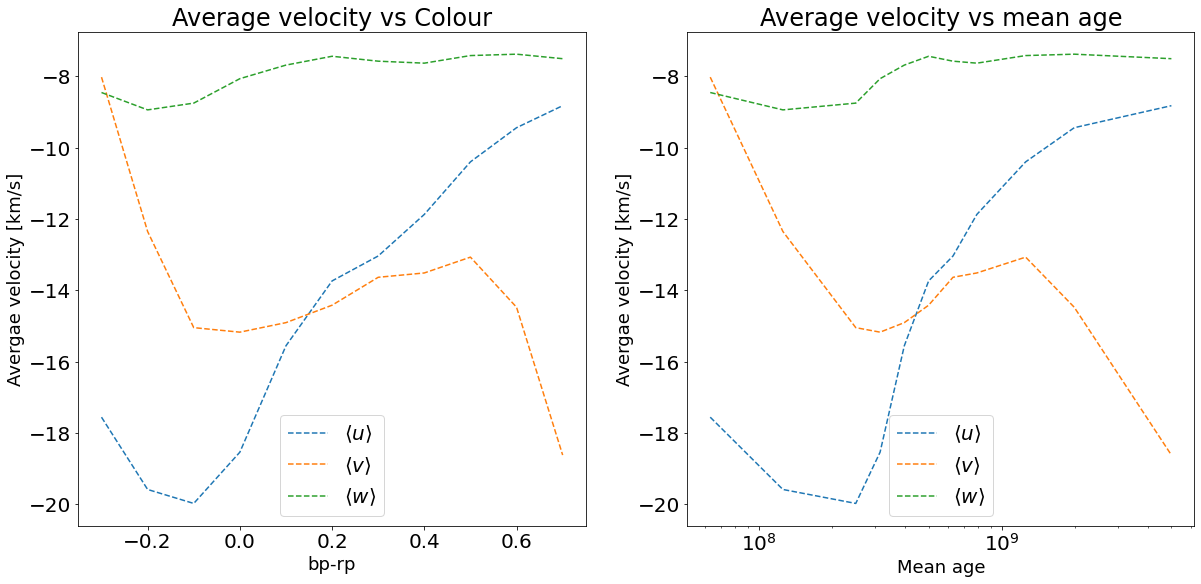

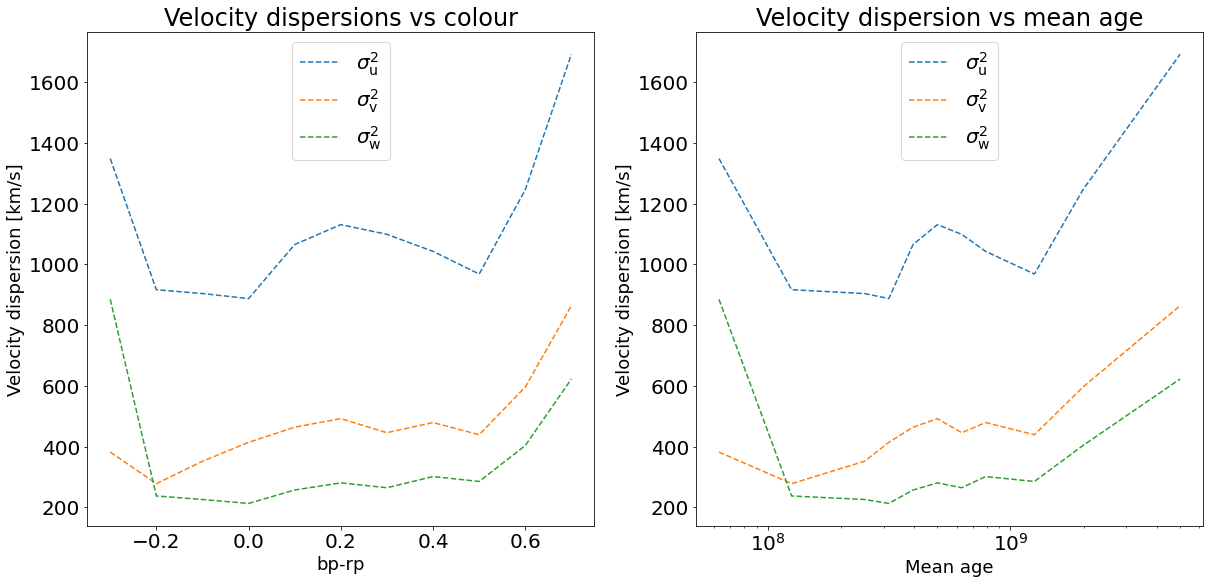

In [441]:
'''Plotting'''

colorinterval = [col for col in np.arange(-0.3,0.8,0.1)]
ages = [1.26e8, 2.51e8, 5.01e8, 6.31e8, 7.94e8, 1e9, 1.26e9, 1.58e9, 2.51e9, 3.98e9, 1e10]
meanages = []
for i in ages:
    meanages.append(i/2)
u_av = [v_m[i][0].value for i in range(len(N))]
v_av = [v_m[i][1].value for i in range(len(N))]
w_av = [v_m[i][2].value for i in range(len(N))]

disp_u = [disp[i][0].value for i in range(len(N))]
disp_v = [disp[i][1].value for i in range(len(N))]
disp_w = [disp[i][2].value for i in range(len(N))]

plt.figure(1)
plt.rcParams['font.size'] = 20
fig = plt.figure(figsize=(20, 20))
fig.add_subplot(221)
plt.title('Average velocity vs Colour')
plt.xlabel(r'bp-rp', fontsize = 18)
plt.ylabel('Avergae velocity [km/s]', fontsize = 18)
plt.plot(colorinterval,u_av, '--', label = r'$\langle u \rangle$')
plt.plot(colorinterval,v_av, '--', label = r'$\langle v \rangle$')
plt.plot(colorinterval,w_av, '--', label = r'$\langle w \rangle$')
plt.legend()

fig.add_subplot(222)
plt.title('Average velocity vs mean age')
plt.xscale('log')
plt.xlabel('Mean age', fontsize = 18)
plt.ylabel('Avergae velocity [km/s]', fontsize = 18)
plt.plot(meanages,u_av, '--', label = r'$\langle u \rangle$')
plt.plot(meanages,v_av, '--', label = r'$\langle v \rangle$')
plt.plot(meanages,w_av, '--', label = r'$\langle w \rangle$')
plt.legend()

plt.figure(2)
plt.rcParams['font.size'] = 20
fig = plt.figure(figsize=(20, 20))
fig.add_subplot(221)
plt.title('Velocity dispersions vs colour')
plt.xlabel(r'bp-rp', fontsize = 18)
plt.ylabel('Velocity dispersion [km/s]', fontsize = 18)
plt.plot(colorinterval, disp_x, '--', label = r'$\sigma^2_{\rm{u}}$')
plt.plot(colorinterval, disp_y, '--', label = r'$\sigma^2_{\rm{v}}$')
plt.plot(colorinterval, disp_z, '--', label = r'$\sigma^2_{\rm{w}}$')
plt.legend()

fig.add_subplot(222)
plt.title('Velocity dispersion vs mean age')
plt.xscale('log')
plt.xlabel(r'Mean age', fontsize = 18)
plt.ylabel('Velocity dispersion [km/s]', fontsize = 18)
plt.plot(meanages, disp_x, '--', label = r'$\sigma^2_{\rm{u}}$')
plt.plot(meanages, disp_y, '--', label = r'$\sigma^2_{\rm{v}}$')
plt.plot(meanages, disp_z, '--', label = r'$\sigma^2_{\rm{w}}$')
plt.legend()




In [404]:
'''Calculating ratios in comparison with epicycle theory'''

ratios = []
for i in range(len(N)):
    rat = disp[i][1]/disp[i][0]
    ratios.append(rat)


66374.38150326704 km2 / s2
84287.52940385384 km2 / s2
3312642.774068865 km2 / s2
402890.9448724114 km2 / s2
1609240.0034256845 km2 / s2
2483150.023217273 km2 / s2
1534250.0266803007 km2 / s2
8188023.253152745 km2 / s2
4676997.696101729 km2 / s2
4654055.293057451 km2 / s2
16036752.199285133 km2 / s2


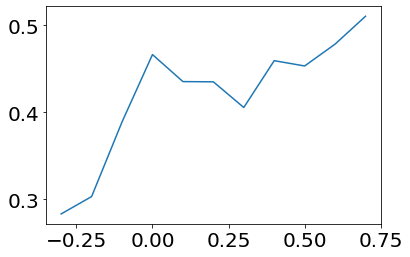

In [534]:
'''Calculation with new dispersions'''
Ratios = []

for i in range(len(N)):
    Ratios.append(disp_y[i]/disp_x[i])

plt.plot(colorinterval,Ratios)

(array([0.03592379, 1.20712205]),
 array([0.10165803, 0.44244485]),
 array([0.01494328, 1.12497375]))

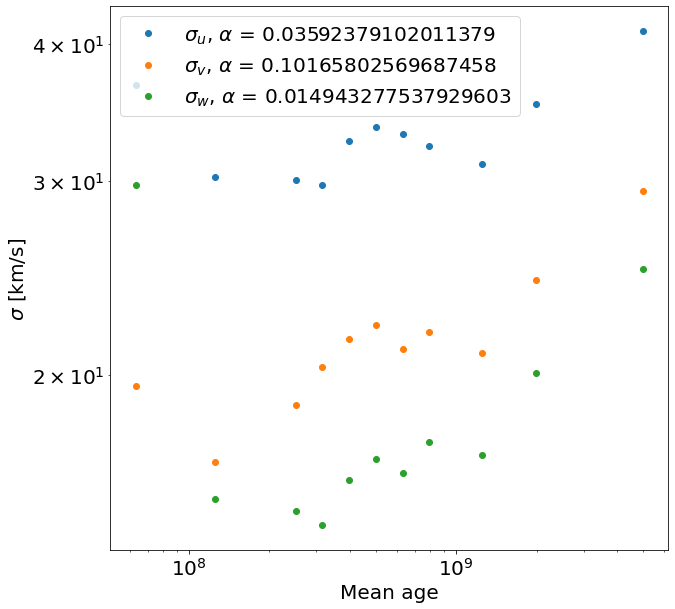

In [593]:
from scipy.optimize import curve_fit

disp_u_sqrt = []
disp_v_sqrt = []
disp_w_sqrt = []
disp_x_sqrt = []
disp_y_sqrt = []
disp_z_sqrt = []


for i in range(len(N)):
    disp_u_sqrt.append(np.sqrt(disp_u[i]))
    disp_v_sqrt.append(np.sqrt(disp_v[i]))
    disp_w_sqrt.append(np.sqrt(disp_w[i]))
    disp_x_sqrt.append(np.sqrt(disp_x[i]))
    disp_y_sqrt.append(np.sqrt(disp_y[i]))
    disp_z_sqrt.append(np.sqrt(disp_z[i]))
    
a1 = np.polyfit(np.log10(meanages),np.log10(disp_x_sqrt),1)
a2 = np.polyfit(np.log10(meanages),np.log10(disp_y_sqrt),1)
a3 = np.polyfit(np.log10(meanages),np.log10(disp_z_sqrt),1)

plt.rcParams['font.size'] = 20
fig = plt.figure(figsize=(10, 10))
#plt.xscale('linear')
#plt.yscale('linear')
#plt.plot(meanages,a1list)
#plt.plot(meanages,a2list)
#plt.plot(meanages,a3list)

#sigmalist = []
#for i in range(len(N)):
#    sigma = np.sqrt(disp_x[i] + disp_y[i] + disp_z[i])
#    sigmalist.append(sigma)
plt.ylabel(r'$\sigma$ [km/s]')
plt.xlabel('Mean age')
plt.xscale('log')
plt.yscale('log')
plt.plot(meanages,disp_x_sqrt, 'o', label = r'$\sigma_u$, $\alpha$ = {}'.format(a1[0]))
plt.plot(meanages,disp_y_sqrt, 'o', label = r'$\sigma_v$, $\alpha$ = {}'.format(a2[0]))
plt.plot(meanages,disp_z_sqrt, 'o', label = r'$\sigma_w$, $\alpha$ = {}'.format(a3[0]))
plt.legend()


a1,a2,a3


#plt.plot(meanages,disp_v_sqrt, 'o', label = r'$\sigma_{\rm{v}}$')
#plt.plot(meanages,disp_w_sqrt, 'o', label = r'$\sigma_{\rm{w}}$')

#plt.legend()

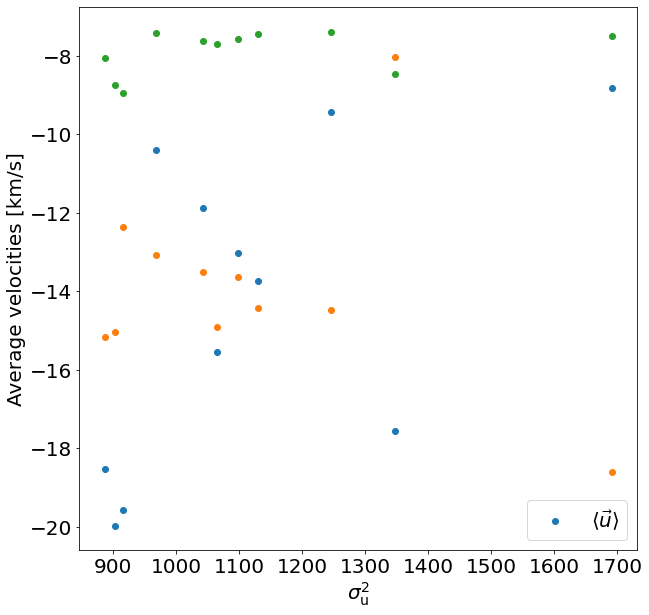

In [481]:



plt.rcParams['font.size'] = 20
fig = plt.figure(figsize=(10, 10))
plt.xlabel(r'$\sigma^2_{\rm{u}}$')
plt.ylabel('Average velocities [km/s]')
plt.plot( disp_x,u_av, 'o', label = r'$\langle \vec{u} \rangle$')
plt.plot(disp_x,v_av, 'o')
plt.plot(disp_x,w_av, 'o')
plt.legend()

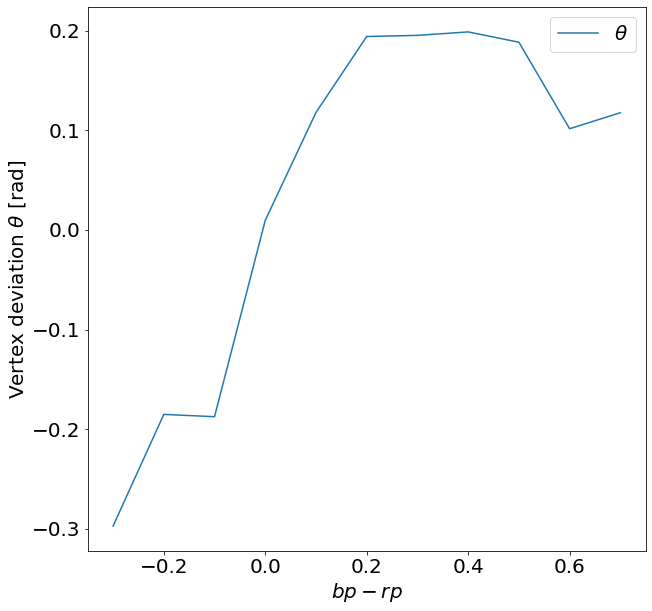

In [551]:
plt.rcParams['font.size'] = 20
fig = plt.figure(figsize=(10, 10))
plt.xlabel(r'$bp-rp$')
plt.ylabel(r'Vertex deviation $\theta$ [rad]')
plt.plot(colorinterval, verticess, label = r'$\theta$')
plt.legend()

In [562]:
'''
G_max = []
Gapp_max = []
distlist = []
for j in range(len(N)):    
    M_Gl = []
    for i in range(len(app)):
        M_G = app[i] + 5*np.log10(p[i]/100)
        M_Gl.append(M_G)
    max_Mg = np.max(app[j])
    
    G_max.append(max_Mg)
    Gapp_max.append(max_app)


    #max_app = np.max(app[j])
    #distance = 10**((max_app - max_Mg + 5)/5)
    #distlist.append(distance)

print(G_max)
print(Gapp_max)
print(distlist)
'''
x = [1,2,3,4,5,6,7,8,9,10,11]

array([ 3.30350000e+08, -9.53327273e+08])

<Quantity [ 1.9249064,  1.970477 ,  2.0226774, ..., 10.999998 , 10.999999 ,
           10.999999 ] mag>